In [1]:
# using Pkg
# Pkg.activate("/home/jek354/research/ML-signproblem")
# Pkg.update()

using Lattices
using LinearAlgebra
using Combinatorics
using SparseArrays
using Plots
import Graphs
using LaTeXStrings
using Statistics
using Random
using Zygote
using Optimization, OptimizationOptimisers
using JSON
using OptimizationOptimJL
using JLD2
# using ExponentialUtilities


include("ed_objects.jl")
include("ed_functions.jl")
include("ed_optimization.jl")
include("utility_functions.jl")

merge_jld2_folder

In [32]:
# using KrylovKit

t = 1.0
U = 6
μ = 0  # positive incentivises fewer particles (one electron costs this much energy)
N_up = 3
N_down = 3
N =  6
half_filling = false
# lattice = Chain(6, Periodic())
lattice_dimension = (2,3)
bc = "periodic"
# lattice = Chain(6, Periodic())
lattice = Square(lattice_dimension, if bc == "periodic" Periodic() else Open() end)
# lattice = Graphs.cycle_graph(3)

models = []

reference_index = 2
# t_values = []# Float64[1,1], Float64[1,0.1], 1.0]
# for _t in t_values
#     # println(_t)
#     push!(models,HubbardModel(_t,0.0001,μ,half_filling))
# end
# U_values = [0.00001,0.01]
U_values = [0.00001; LinRange(2.1,9,20)]
U_values = sort([U_values; 10.0 .^LinRange(-3,2,40)])

for U in U_values
    # println(t)
    push!(models,HubbardModel(t,U,μ,half_filling))
end

subspace = HubbardSubspace(N, lattice)
# subspace = HubbardSubspace(N_up, N_down, lattice)

ops = []
if subspace.N >= 1
    push!(ops,Matrix(create_operator(subspace,:Sx)))
end
push!(ops, Matrix(create_operator(subspace,:S2)))
# op3 = Matrix(create_operator(subspace,:L2))
push!(ops, Matrix(create_operator(subspace,:T, kind=1)))
push!(ops, Matrix(create_operator(subspace,:T, kind=2)))
# push!(ops, Matrix(create_operator(subspace,:σ, kind=1)))
E = []
H = []
V = []
for model ∈ models
    push!(H, Matrix(create_Hubbard(model, subspace; perturbations=false)))
    e, v = eigen(H[end])
    push!(E, e)
    push!(V, v)
end

for i ∈ 1:2
    println(degeneracy_count(E[i]))
end

# println(sum(abs.(h1*h2-h2*h1)))

# ops_tmp = [H[1], ops...]
# for i in eachindex(ops_tmp)
#     for j in i+1:length(ops_tmp)
#         println("($i,$j) ", sum(abs.(ops_tmp[i]*ops_tmp[j] - ops_tmp[j]*ops_tmp[i])))
#     end
# end

# H1 = create_Hubbard(model, subspace; perturbations=false)
# E1 = diag(V1'*Matrix(H1)*V1)

# @time degen_rm_U = create_consistent_basis(H, ops;reference_index=reference_index)

dim = get_subspace_dimension(subspace)
indexer = CombinationIndexer(reduce(vcat,collect(sites(subspace.lattice))), get_subspace_info(subspace)...)
# difference_dict = collect_all_conf_differences(indexer)


Dict{Any, Any}(5 => 2, 35 => 1, 20 => 2, 12 => 1, 8 => 2, 37 => 1, 6 => 59, 14 => 4, 3 => 6, 7 => 3, 4 => 6, 13 => 5, 2 => 49, 10 => 12)
Dict{Any, Any}(5 => 2, 4 => 6, 6 => 62, 7 => 2, 2 => 57, 10 => 12, 13 => 3, 35 => 1, 3 => 44, 19 => 1)


CombinationIndexer{Coordinate{2, Int64}}(Coordinate{2, Int64}[Coordinate(1, 1), Coordinate(2, 1), Coordinate(1, 2), Coordinate(2, 2), Coordinate(1, 3), Coordinate(2, 3)], Dict{Tuple{Set{Coordinate{2, Int64}}, Set{Coordinate{2, Int64}}}, Int64}((Set([Coordinate(1, 3), Coordinate(2, 1)]), Set([Coordinate(1, 2), Coordinate(1, 1), Coordinate(2, 2), Coordinate(2, 1)])) => 143, (Set([Coordinate(1, 3), Coordinate(1, 1), Coordinate(2, 3)]), Set([Coordinate(2, 2), Coordinate(1, 1), Coordinate(2, 3)])) => 451, (Set([Coordinate(1, 3), Coordinate(2, 2), Coordinate(2, 3)]), Set([Coordinate(1, 3), Coordinate(1, 2), Coordinate(2, 3)])) => 661, (Set([Coordinate(1, 3), Coordinate(1, 2), Coordinate(1, 1), Coordinate(2, 1)]), Set([Coordinate(1, 3), Coordinate(2, 2)])) => 690, (Set([Coordinate(2, 2), Coordinate(2, 1), Coordinate(2, 3)]), Set([Coordinate(1, 2), Coordinate(2, 1), Coordinate(2, 3)])) => 555, (Set([Coordinate(1, 2), Coordinate(2, 2)]), Set([Coordinate(1, 3), Coordinate(2, 2), Coordinate(2, 1)

In [6]:
# sum(abs,diag(degen_rm_U[1]'*degen_rm_U[2]-I))
maximum(abs,diag(degen_rm_U[1]*degen_rm_U[2]'-I))

0.050783667403141136

In [8]:
t_dict = Dict{Vector{Tuple{Coordinate{2,Int64},Int,Symbol}}, Float64}()

for s1 in indexer.a
    if [(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)] ∉ keys(t_dict)
        t_dict[[(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)]] = 1
    else
        t_dict[[(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)]] += 1
    end
end
rows = Int[]
cols = Int[]
vals = Float64[]
general_n_body!(rows, cols, vals, t_dict, indexer)
H2 = Matrix(sparse(rows, cols, vals, length(degen_rm_U[50][:,97]), length(degen_rm_U[50][:,97])))

state = degen_rm_U[50][:,97]
state'*H2*state
# indexer.inv_comb_dict[argmax(diag(H2))]

3

In [33]:
t_dict = create_randomized_nth_order_operator(2, indexer; hermitian=true, conserve_spin=false)
reduced, param_map = force_operator_symmetry(t_dict, size(lattice), (1,2), (1,2))
rows, cols, signs, ops_list = build_n_body_structure(t_dict, indexer)
reduced .= 0
reduced[1] = 1
dim = length(indexer.inv_comb_dict)
vals = update_values(signs, ops_list, collect(keys(t_dict)),reduced, param_map)
new_rows = []
new_cols = []
new_vals = []
for i in eachindex(vals)
    if !(vals[i] ≈ 0)
        push!(new_rows, rows[i])
        push!(new_cols, cols[i])
        push!(new_vals, vals[i])
    end
end
x = make_hermitian(sparse(new_rows,new_cols, new_vals, dim, dim))
x
# for i in eachindex(rows)
#     if rows[i] != cols[i] && !(x[cols[i], rows[i]] ≈ 0)
#         println("Bad: $i $(x[cols[i], rows[i]]) $(x[rows[i], cols[i]])")
#     end
# end

924×924 SparseMatrixCSC{Any, Int64} with 280 stored entries:
⎡⠠⠆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⡀⢈⡁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠁⠈⠀⠀⠀⠀⢤⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠋⠀⠀⠈⠠⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⢓⡀⠀⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠦⠀⠀⠰⠂⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⠆⠀⠀⠁⠑⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⣠⡀⠀⠀⠑⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢅⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⢄⠀⠀⠀⠠⠆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠰⠂⠀⠀⠀⠑⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⢑⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢄⠀⠀⠈⠋⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⢄⢀⠀⠀⠰⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠠⠆⠀⠀⠲⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⠀⠈⢥⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠂⡀⠀⠀⣠⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠓⠀⠀⠀⠀⡀⢀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢈⡁⠈⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠰⠂⎦

In [7]:
# state = degen_rm_U[1][:,1]
k = 50
args = correlation_matrix(1, indexer)
for i in axes(V[1][:,1:100],2)
    state1 = degen_rm_U[1][:,i]
    state2 = degen_rm_U[k][:,i]
    U_value = U_values[k]
    energy = real.(diag(degen_rm_U[k]'*H[k]*degen_rm_U[k])[i])
    println("state #:$i U=$U_value energy: $(energy) \t U=0,!=0 SD?:$(is_slater_determinant(state1, indexer; correlation_args=args)) $(is_slater_determinant(state2, indexer; correlation_args=args))   \t overlap: $(real(degen_rm_U[1][:,i]'*degen_rm_U[k][:,i]))")
end
# γ = compute_correlation(state, 1, indexer)
# println("rank(γ)=$(rank(γ))  sum(γ^2 -γ)=$(sum(abs.(γ^2-γ)))")
# eigvals(Matrix(mats[4,4]))

state #:1 U=8.273684210526316 energy: -0.9999999999999999 	 U=0,!=0 SD?:false false   	 overlap: 0.9999999999999998
state #:2 U=8.273684210526316 energy: 4.99999999999999 	 U=0,!=0 SD?:false false   	 overlap: 0.9999999999999987
state #:3 U=8.273684210526316 energy: 1.9999999999999993 	 U=0,!=0 SD?:false false   	 overlap: 1.0
state #:4 U=8.273684210526316 energy: -1.999999999999999 	 U=0,!=0 SD?:false false   	 overlap: 0.9999999999999993
state #:5 U=8.273684210526316 energy: 5.999999999999998 	 U=0,!=0 SD?:false false   	 overlap: 0.9999999999999994
state #:6 U=8.273684210526316 energy: -1.9999999999999991 	 U=0,!=0 SD?:false false   	 overlap: 1.0
state #:7 U=8.273684210526316 energy: -1.999999999999999 	 U=0,!=0 SD?:false false   	 overlap: 0.9999999999999996
state #:8 U=8.273684210526316 energy: 13.92041225692679 	 U=0,!=0 SD?:false false   	 overlap: 0.8514029641263088
state #:9 U=8.273684210526316 energy: 10.854818110491724 	 U=0,!=0 SD?:false false   	 overlap: 0.71016992031134

In [15]:
maximum(indexer.a).coordinates

(2, 3)

In [25]:
include("ed_objects.jl")
include("ed_functions.jl")
include("ed_optimization.jl")
include("utility_functions.jl")

meta_data = Dict("electron count"=>3, "sites"=>"2x3", "bc"=>"periodic", "basis"=>"adiabatic", 
                "U_values"=>U_values, "maxiters"=>20)
instructions = Dict("starting state"=>Dict("U index"=>1, "levels"=>100),
                "ending state"=>Dict("U index"=>40, "levels"=>100), "max_order"=>2, "use symmetry"=>true)
println("U in [",U_values[instructions["starting state"]["U index"]], ", ", U_values[instructions["ending state"]["U index"]],"]")
data_dict_tmp = test_map_to_state(degen_rm_U, instructions, indexer, !isa(meta_data["electron count"], Number);
     maxiters=meta_data["maxiters"], optimization=:gradient)
data_dict_tmp
# save_with_metadata(data_dict_tmp, "data/tmp.jld2")

U in [1.0e-5, 5.2233450742668435]
magnitude: 0.03958206663501357
learning rate: 0.007916413327002714
  2.093445 seconds (334.90 k allocations: 15.028 MiB, 99.91% compilation time)
  1.107648 seconds (362.32 k allocations: 34.674 MiB, 60.31% compilation time)
  2.036004 seconds (381.60 k allocations: 18.451 MiB, 99.38% compilation time)
0.08195906657730423
0.08195906657730423
0.10075300377110918
0.10075300377110918
0.07990376931283716
0.07990376931283716
0.0794278933306879
0.0794278933306879
0.08150021452257039
0.08150021452257039
0.0793314733595557
0.0793314733595557
0.07922186552086885
0.07922186552086885
0.08057380799019631
0.08057380799019631
0.07922074488919395
0.07922074488919395
0.07918853656468594
0.07918853656468594
0.07926175827266368
0.07926175827266368
0.07917644629729192
0.07917644629729192
0.07916877914931753
0.07916877914931753
0.07927059440452044
0.07927059440452044
0.07916873810249603
0.07916873810249603
0.0791673041136991
0.0791673041136991
0.07917181213807079
0.079171

Dict{String, Any} with 10 entries:
  "loss_std_metrics"   => Any[Any[0.0, 0.000166981, 0.00466401]]
  "loss_metrics"       => Any[Any[0.0791641, 0.0791641, 4.60616e-6]]
  "coefficients"       => Any[Any[[6.72204e-9, 8.56195e-9, -0.0043765, -7.03747…
  "param_mapping"      => Any[[1, 2, 3, 4, 5, 6, 7, 8, 4, 9  …  12, 14, 21, 4, …
  "coefficient_labels" => Any[Vector{Tuple{Coordinate{2, Int64}, Int64, Symbol}…
  "labels"             => Any[Dict("starting state"=>Dict("U index"=>1, "level"…
  "all_matrices"       => Any[Any[sparse([1, 2, 3, 4, 5, 6, 7, 11, 12, 13  …  2…
  "other_metrics"      => Vector{Any}[[ * Status: failure (reached maximum numb…
  "norm2_metrics"      => Any[[0.398699, 2.91971]]
  "norm1_metrics"      => Any[[7.75744, 372.617]]

In [24]:
data_dict_tmp["other_metrics"][1]

2-element Vector{Any}:
  * Status: success

 * Candidate solution
    Final objective value:     4.141432e-04

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 8.57e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.54e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.04e-13 ≰ 0.0e+00
    |g(x)|                 = 1.40e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    14
    f(x) calls:    38
    ∇f(x) calls:   38

  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     2.683049e-09

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.13e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.58e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.53e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.70e-01 ≰ 0.0e+00
    |g(x)|                 = 4.44e-06 ≰ 1.0e-08

 * Work counters
    Seconds

In [22]:
data_dict_tmp["other_metrics"][1]

2-element Vector{Any}:
  * Status: success (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     4.141432e-04

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.50e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.32e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.66e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.61e-12 ≰ 0.0e+00
    |g(x)|                 = 8.43e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   32  (vs limit Inf)
    Iterations:    20
    f(x) calls:    54
    ∇f(x) calls:   54

  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     6.405987e-14

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 6.79e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.42e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.26e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.97e+00 ≰ 0.0e+00
    |g(x)|                 = 2.10e-08 

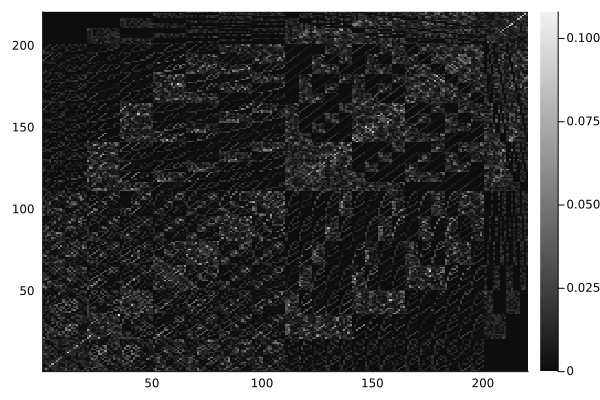

In [114]:
heatmap(Matrix(abs.(data_dict_tmp["all_matrices"][1][2])), cmap=:grays)

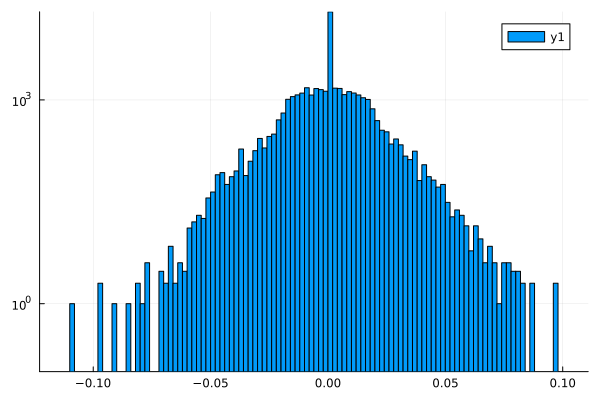

In [115]:
histogram(Matrix(data_dict_tmp["all_matrices"][1][2])[:], bins=100, yscale=:log10)

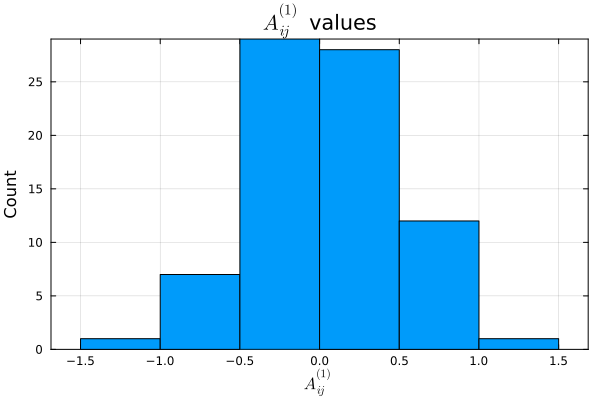

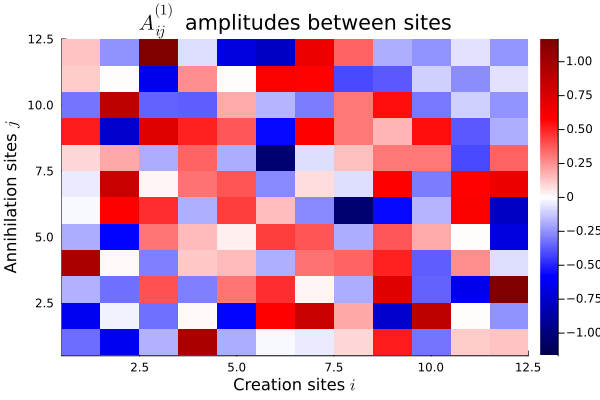

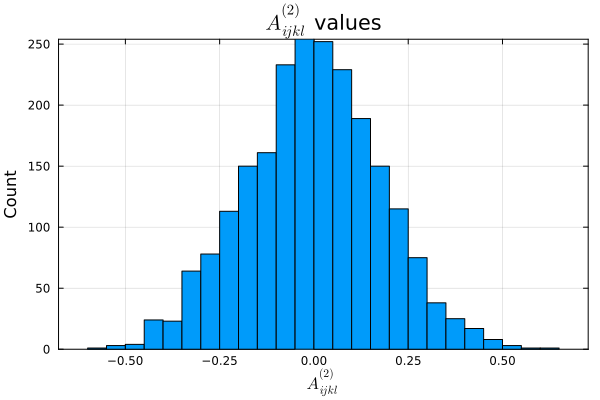

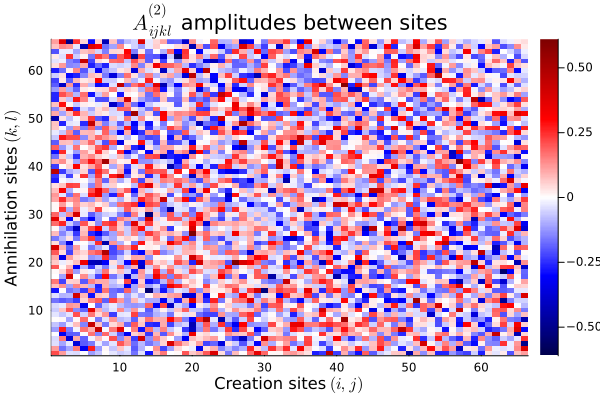

In [141]:
function extract_creates_and_annihilates(term)
    creates = [(op[1].coordinates..., op[2]) for op in term if op[3] == :create]
    annihilates = [(op[1].coordinates..., op[2]) for op in term if op[3] == :annihilate]
    return creates, annihilates
end
function sort_labels(arr::Vector{<:AbstractVector{<:Tuple}})
    # println(arr[1])
    # println(hcat([reverse(collect(u)) for u in arr[1]]...)'[:])
    sort(arr; by = x-> hcat([reverse(collect(u)) for u in x]...)'[:])
end

# using StatsBase
unzip(a) = map(x->getfield.(a, x), fieldnames(eltype(a)))
function heatmap_terms(info, weights; Lx=2, Ly=3)
    labels = Dict()
    creates,_ = unzip(info)

    # println(info[1][1])
    d = unique(creates)
    d = sort_labels(d)
    for (i,c) in enumerate(d)
        labels[c] = i
    end
    # display(d)
    mat = zeros(length(values(labels)), length(values(labels)))
    

    for ((label1, label2), w) in zip(info, weights)
        mat[labels[label1], labels[label2]] = w
        if mat[labels[label2], labels[label1]] ≈ 0 && labels[label2] != labels[label1]
            mat[labels[label2], labels[label1]] = w
        elseif labels[label2] != labels[label1]
            println("woah override")
        end

    end
    mat

end

for (i, (label, ax_label)) in enumerate(zip(["A^{(1)}_{ij}","A^{(2)}_{ijkl}"],[["i","j"], ["(i,j)","(k,l)"]]))
    
    p1 = histogram(data_dict_tmp["coefficients"][1][i], legend=nothing,
        xlabel=L"%$label", ylabel="Count", title=L"$%$label$ values", framestyle=:box)
    # println(ax_label[1])
    mat = heatmap_terms([extract_creates_and_annihilates(t) for t in data_dict_tmp["coefficient_labels"][i]], data_dict_tmp["coefficients"][1][i]; Lx=2, Ly=3)
    upper_bound = maximum(abs, mat)
    p2 = heatmap(mat; colormap=:seismic, clims=(-upper_bound, upper_bound),
            title=L"$%$label$ amplitudes between sites",
            xlabel=L"Creation sites $%$(ax_label[1])$", ylabel=L"Annihilation sites $%$(ax_label[2])$"
            )
    display(p1)
    display(p2)
    for filetype in ["png", "svg", "pdf"]
        savefig(p1, "single_state_map_images/$(label)_histogram_differentE.$filetype")
        savefig(p2, "single_state_map_images/$(label)_heatmap_differentE.$filetype")
    end
end


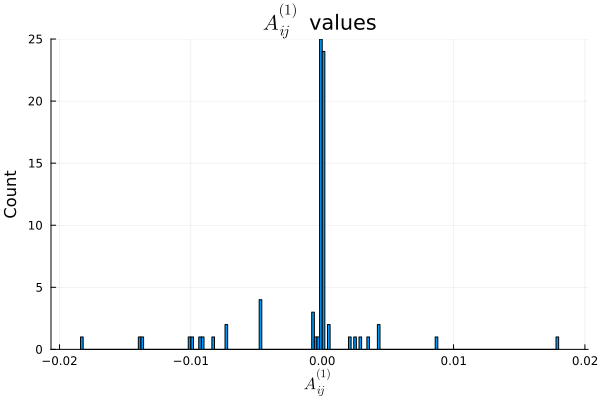

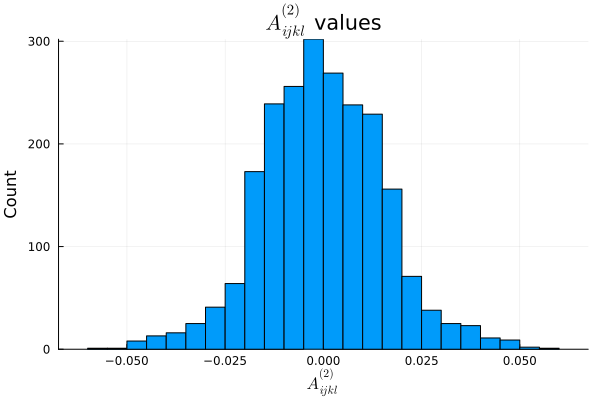

In [125]:
for (i, label) in enumerate(["A^{(1)}_{ij}","A^{(2)}_{ijkl}"])
    
    p = histogram(data_dict_tmp["coefficients"][1][i], legend=nothing,
        xlabel=L"%$label", ylabel="Count", title=L"$%$label$ values")
    display(p)
    for filetype in ["png", "svg", "pdf"]
        savefig(p, "single_state_map_images/$(label)_histogram.$filetype")
    end
end

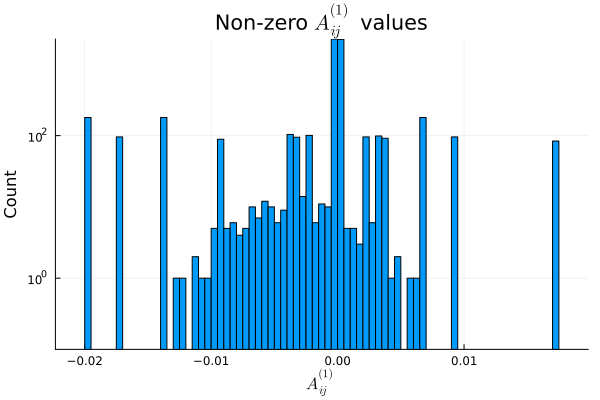

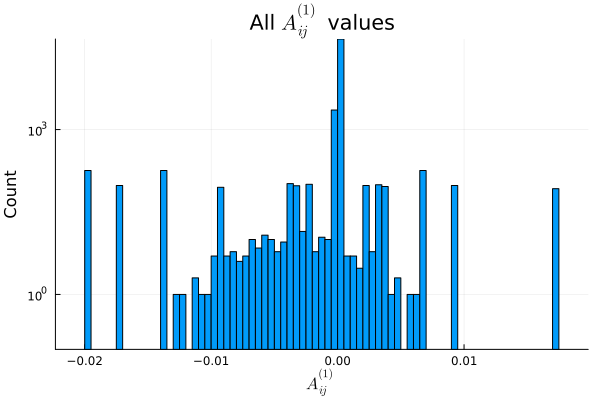

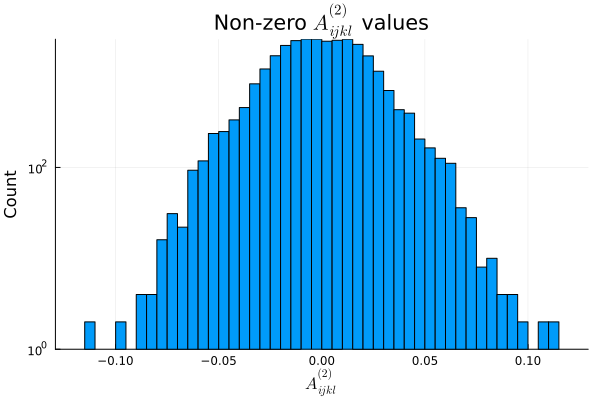

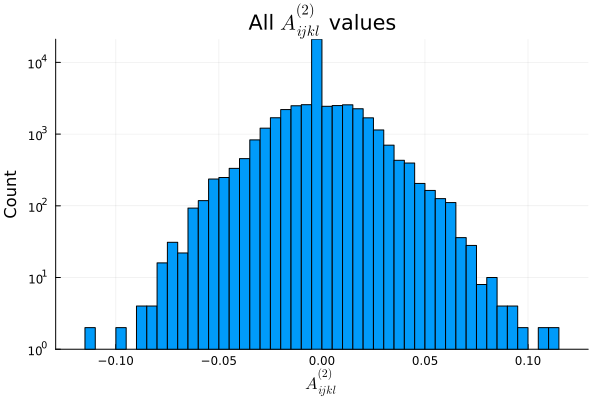

0.8727272727272728
0.38181818181818183


In [76]:
for (label, i) in zip(["A^{(1)}_{ij}","A^{(2)}_{ijkl}"], 1:2)
    data = vec(data_dict_tmp["all_matrices"][1][i])
    filt = abs.(data) .> 0
    p1=histogram(data[filt], bins=100, yaxis=:log10, xlabel=L"%$label", ylabel="Count", legend=nothing, title=L"Non-zero $%$label$ values")
    display(p1)
    p2=histogram(data, bins=100, yaxis=:log10, xlabel=L"%$label", ylabel="Count", legend=nothing, title=L"All $%$label$ values")
    display(p2)
    println(1-sum(filt)/length(data))
    # for filetype in ["png", "svg", "pdf"]
    #     savefig(p1, "single_state_map_images/$(label)_histogram_withoutzero.$filetype")
    #     savefig(p1, "single_state_map_images/$(label)_histogram.$filetype")
    # end
end

In [74]:
data = Matrix(data_dict_tmp["all_matrices"][1][1])
max_val = maximum(abs.(data))
p1 = heatmap(data, 
    xlabel=L"i", ylabel=L"j", title=L"A^{(1)}_{ij}", cmap=:seismic, 
    clims=(-max_val, max_val))
p2= heatmap(Matrix(data_dict_tmp["all_matrices"][1][2]), xlabel=L"(i,j)", ylabel=L"(k,l)", title=L"A^{(2)}_{ijkl}", cmap=:seismic)
for filetype in ["png", "svg", "pdf"]
    savefig(p1, "single_state_map_images/A^{(1)}_{ij})_heatmap.$filetype")
    savefig(p2, "single_state_map_images/A^{(2)}_{ijkl}_heatmap.$filetype")
end

In [20]:
data_dict_tmp2 = data_dict_tmp

Dict{String, Any} with 6 entries:
  "loss_std_metrics" => Any[Any[0.0, 0.00220718, 0.0469683]]
  "loss_metrics"     => Any[Any[0.123184, 0.123184, 5.0267e-6]]
  "meta_data"        => Dict{String, Any}("U_values"=>[1.0e-5, 0.001, 0.0013434…
  "labels"           => Any[Dict("starting state"=>Dict("U index"=>1, "level"=>…
  "norm2_metrics"    => Any[[0.428074, 3.90652]]
  "norm1_metrics"    => Any[[14.5274, 529.567]]

HEY
YOU
YOU


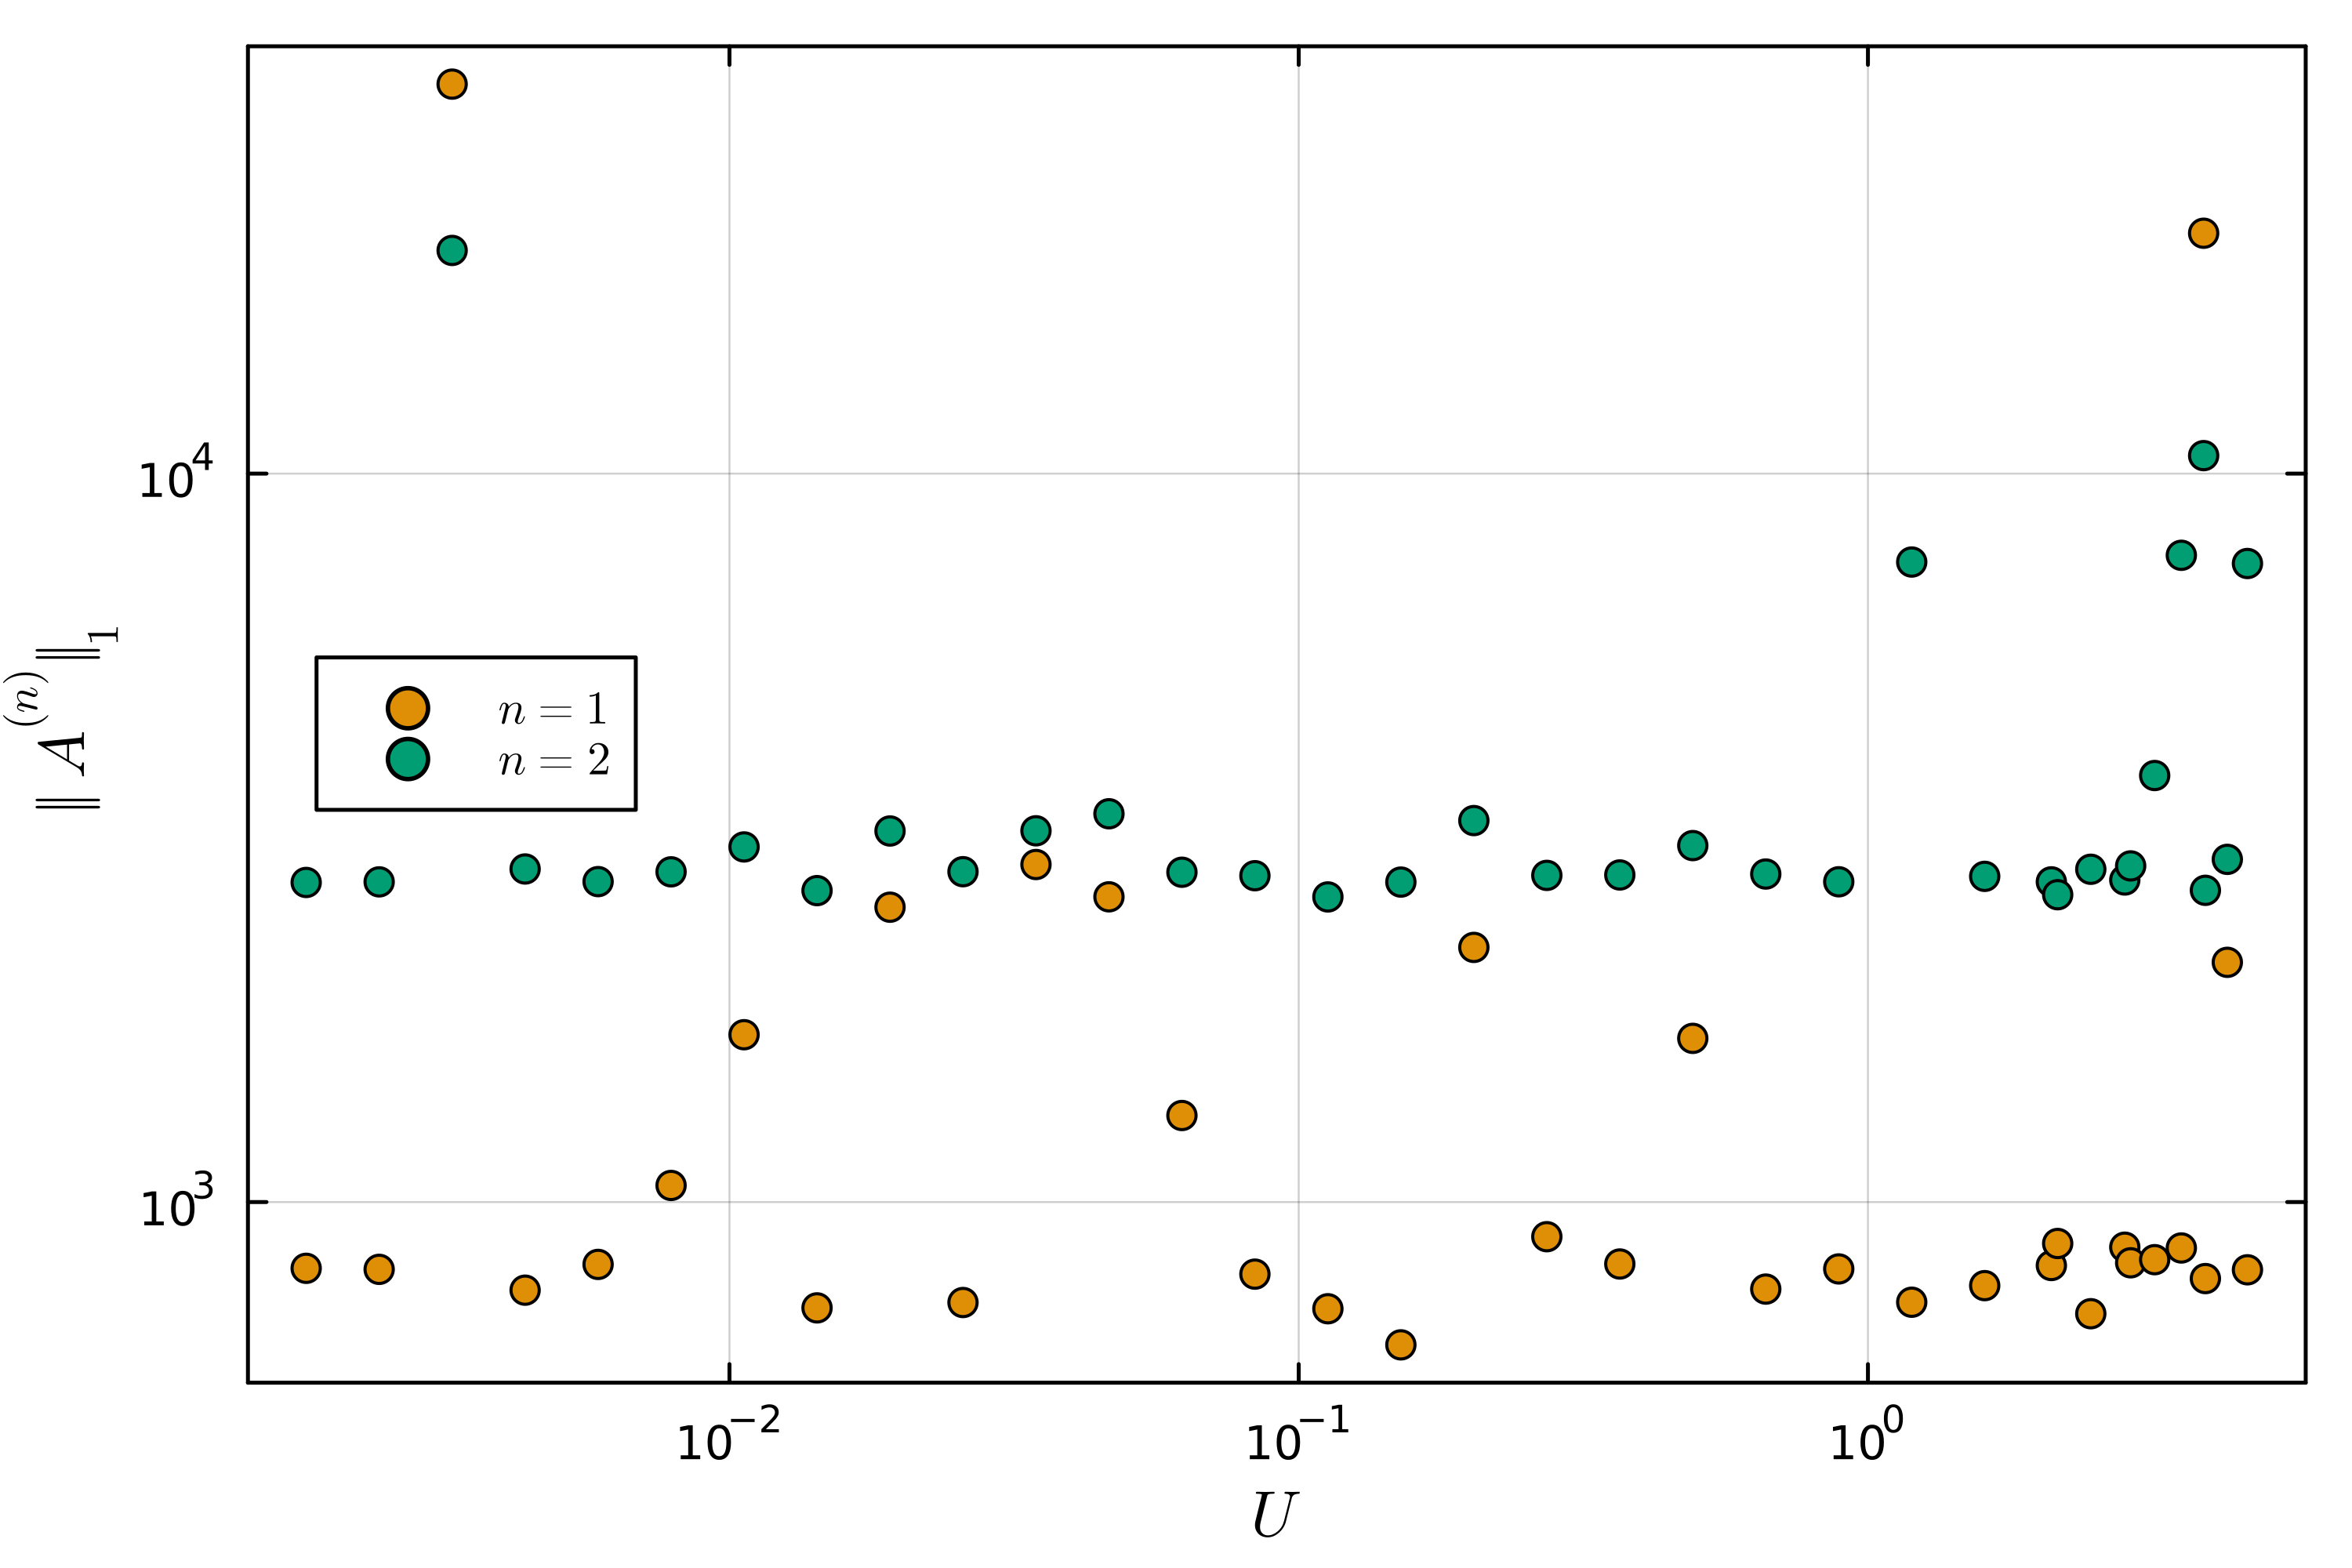

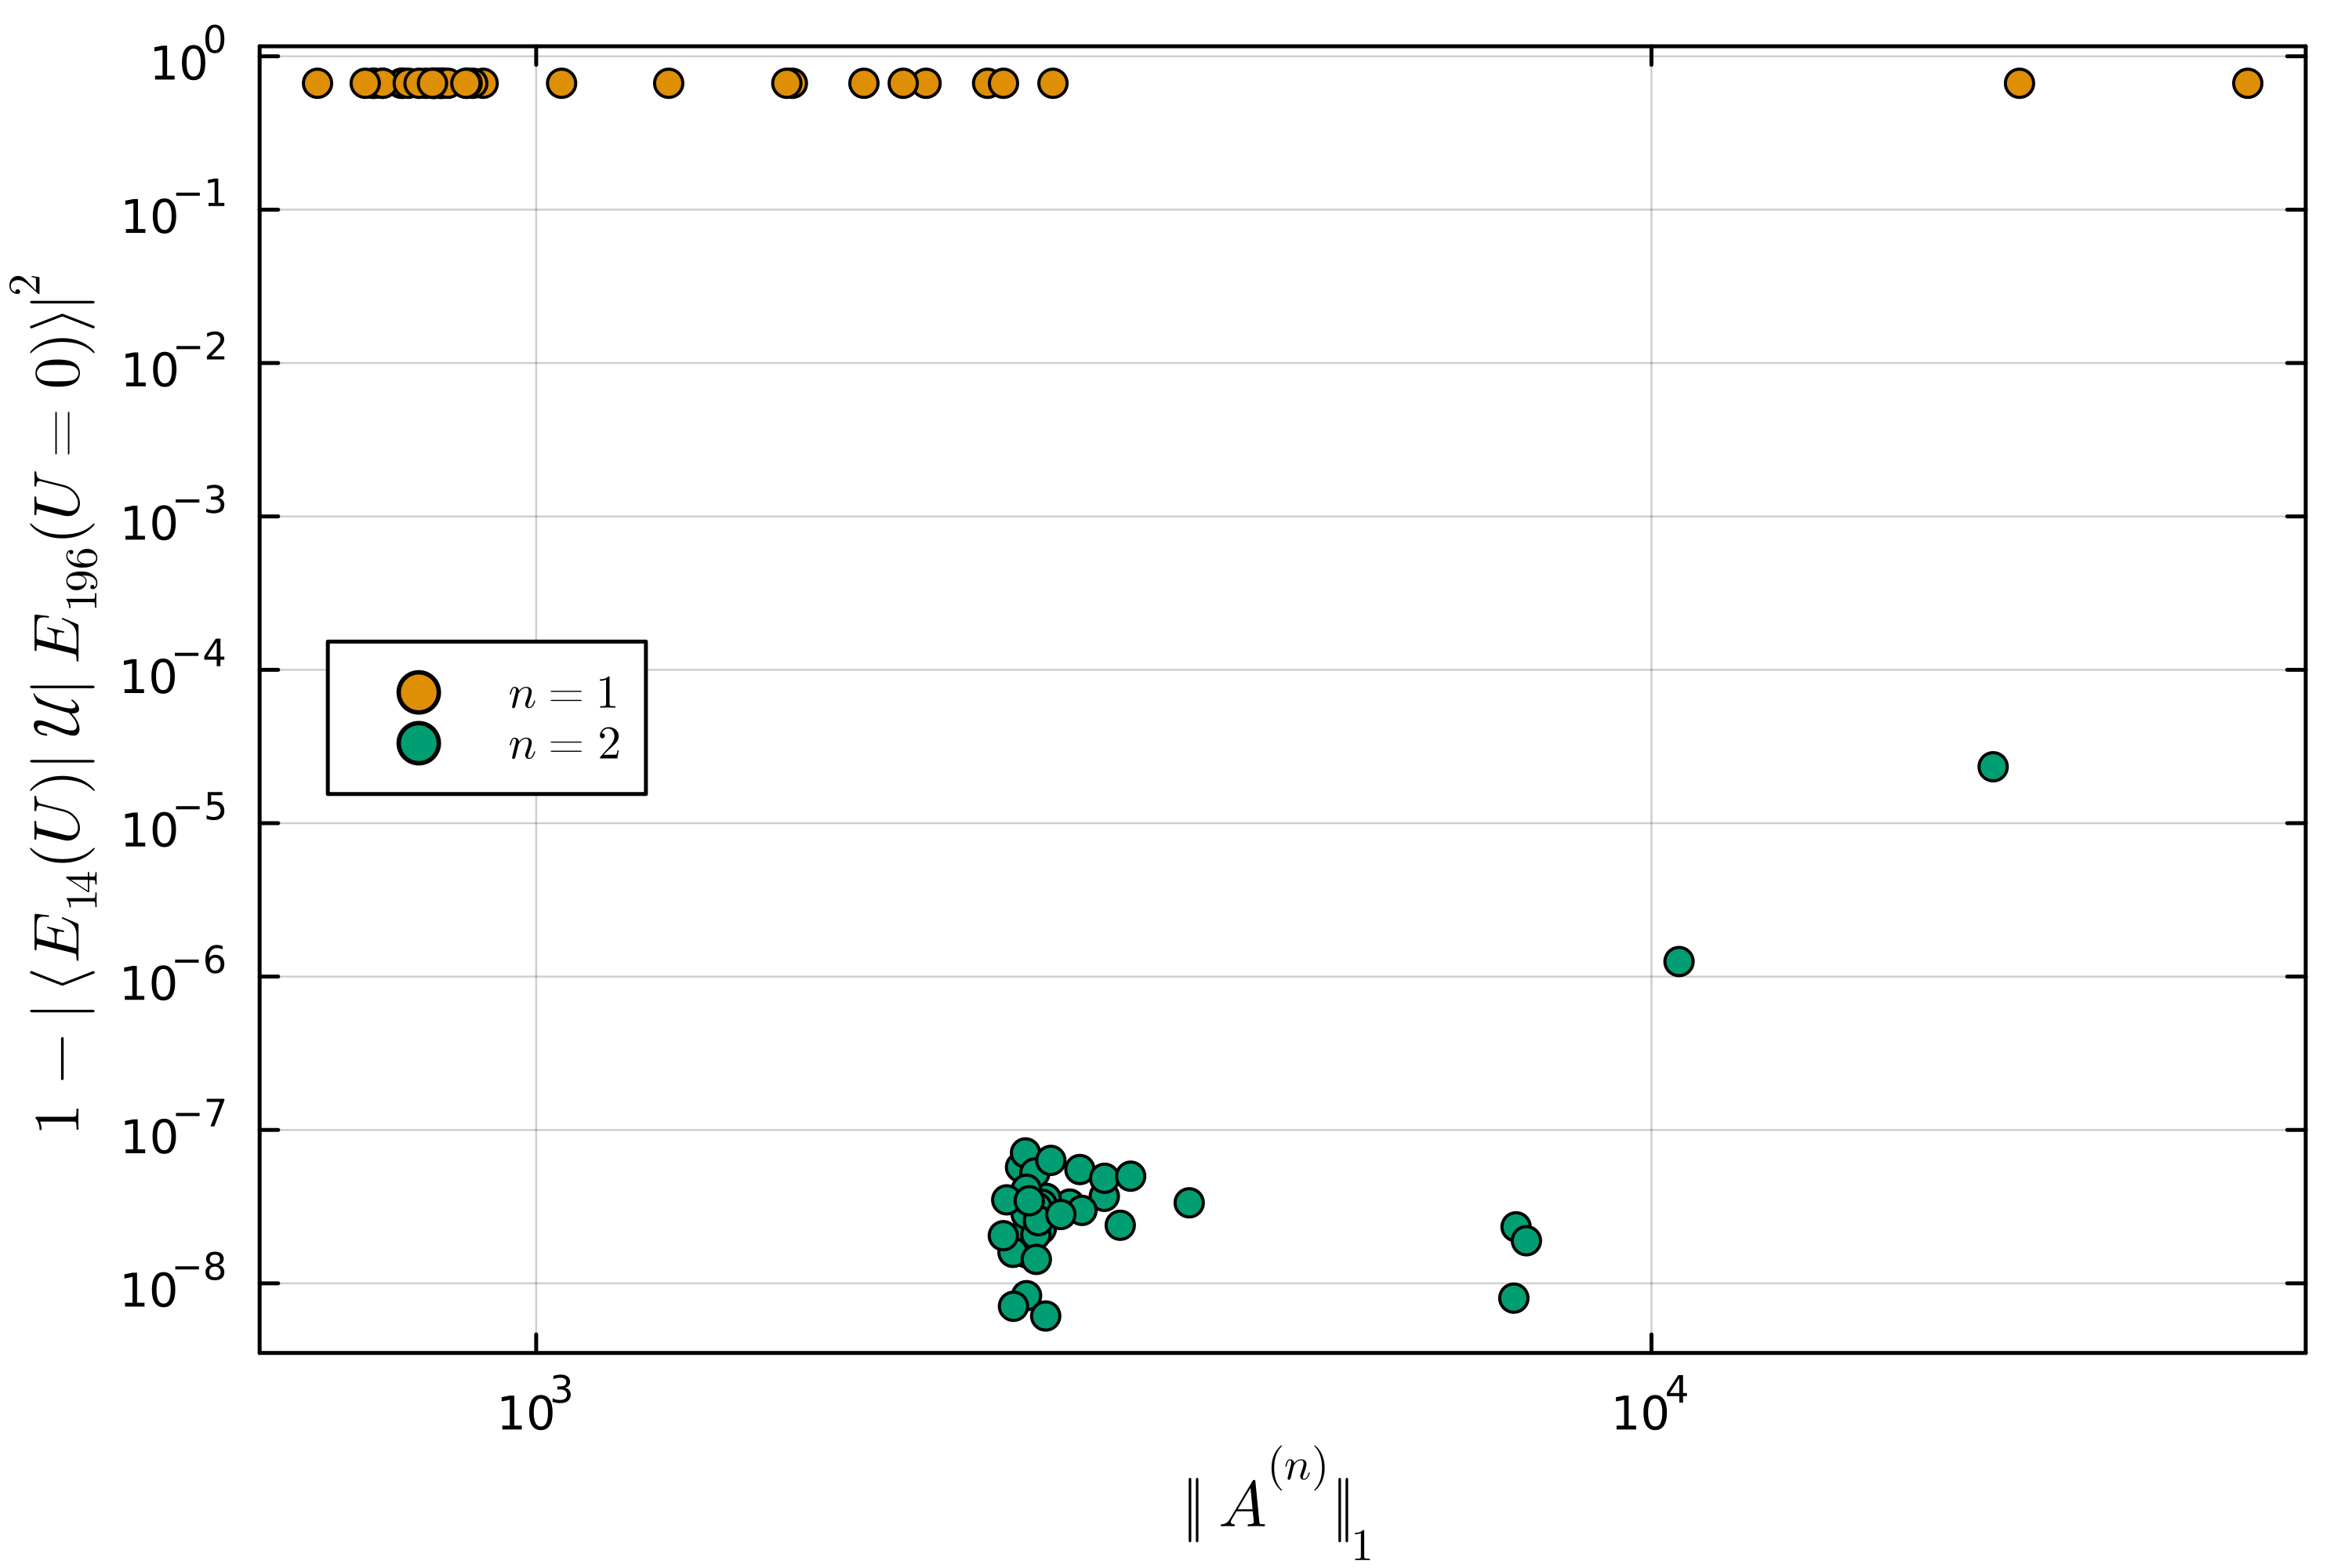

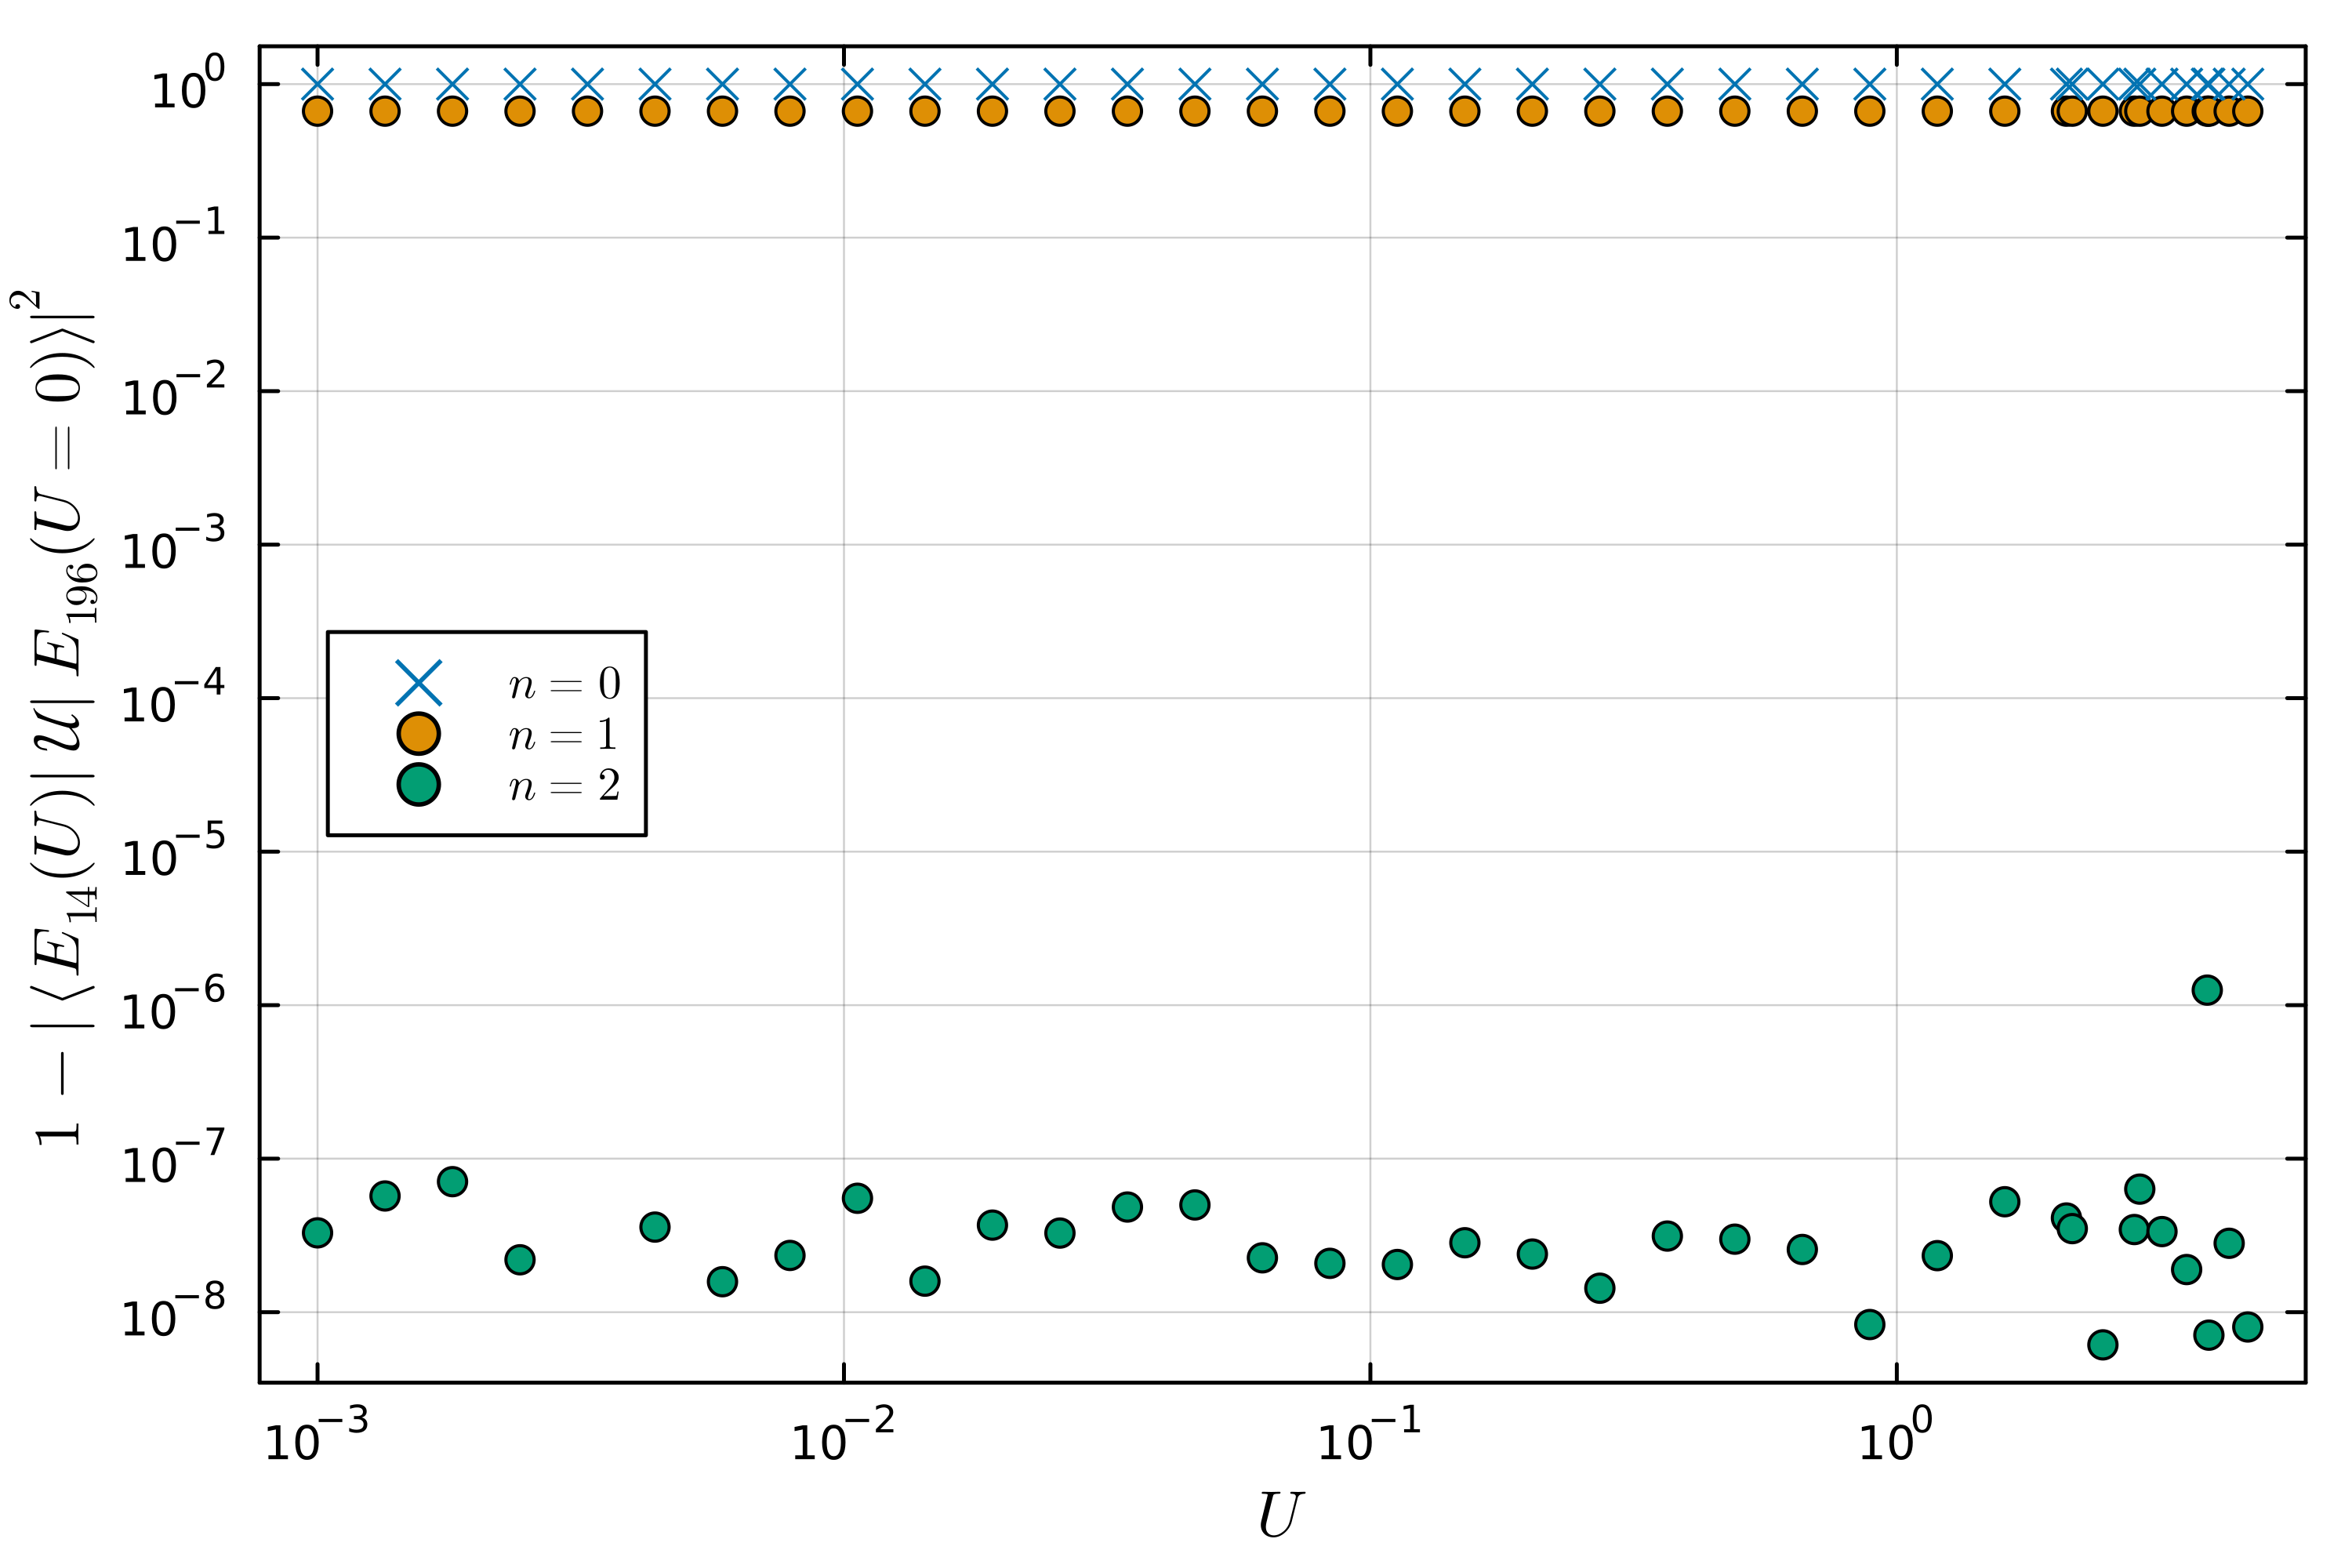

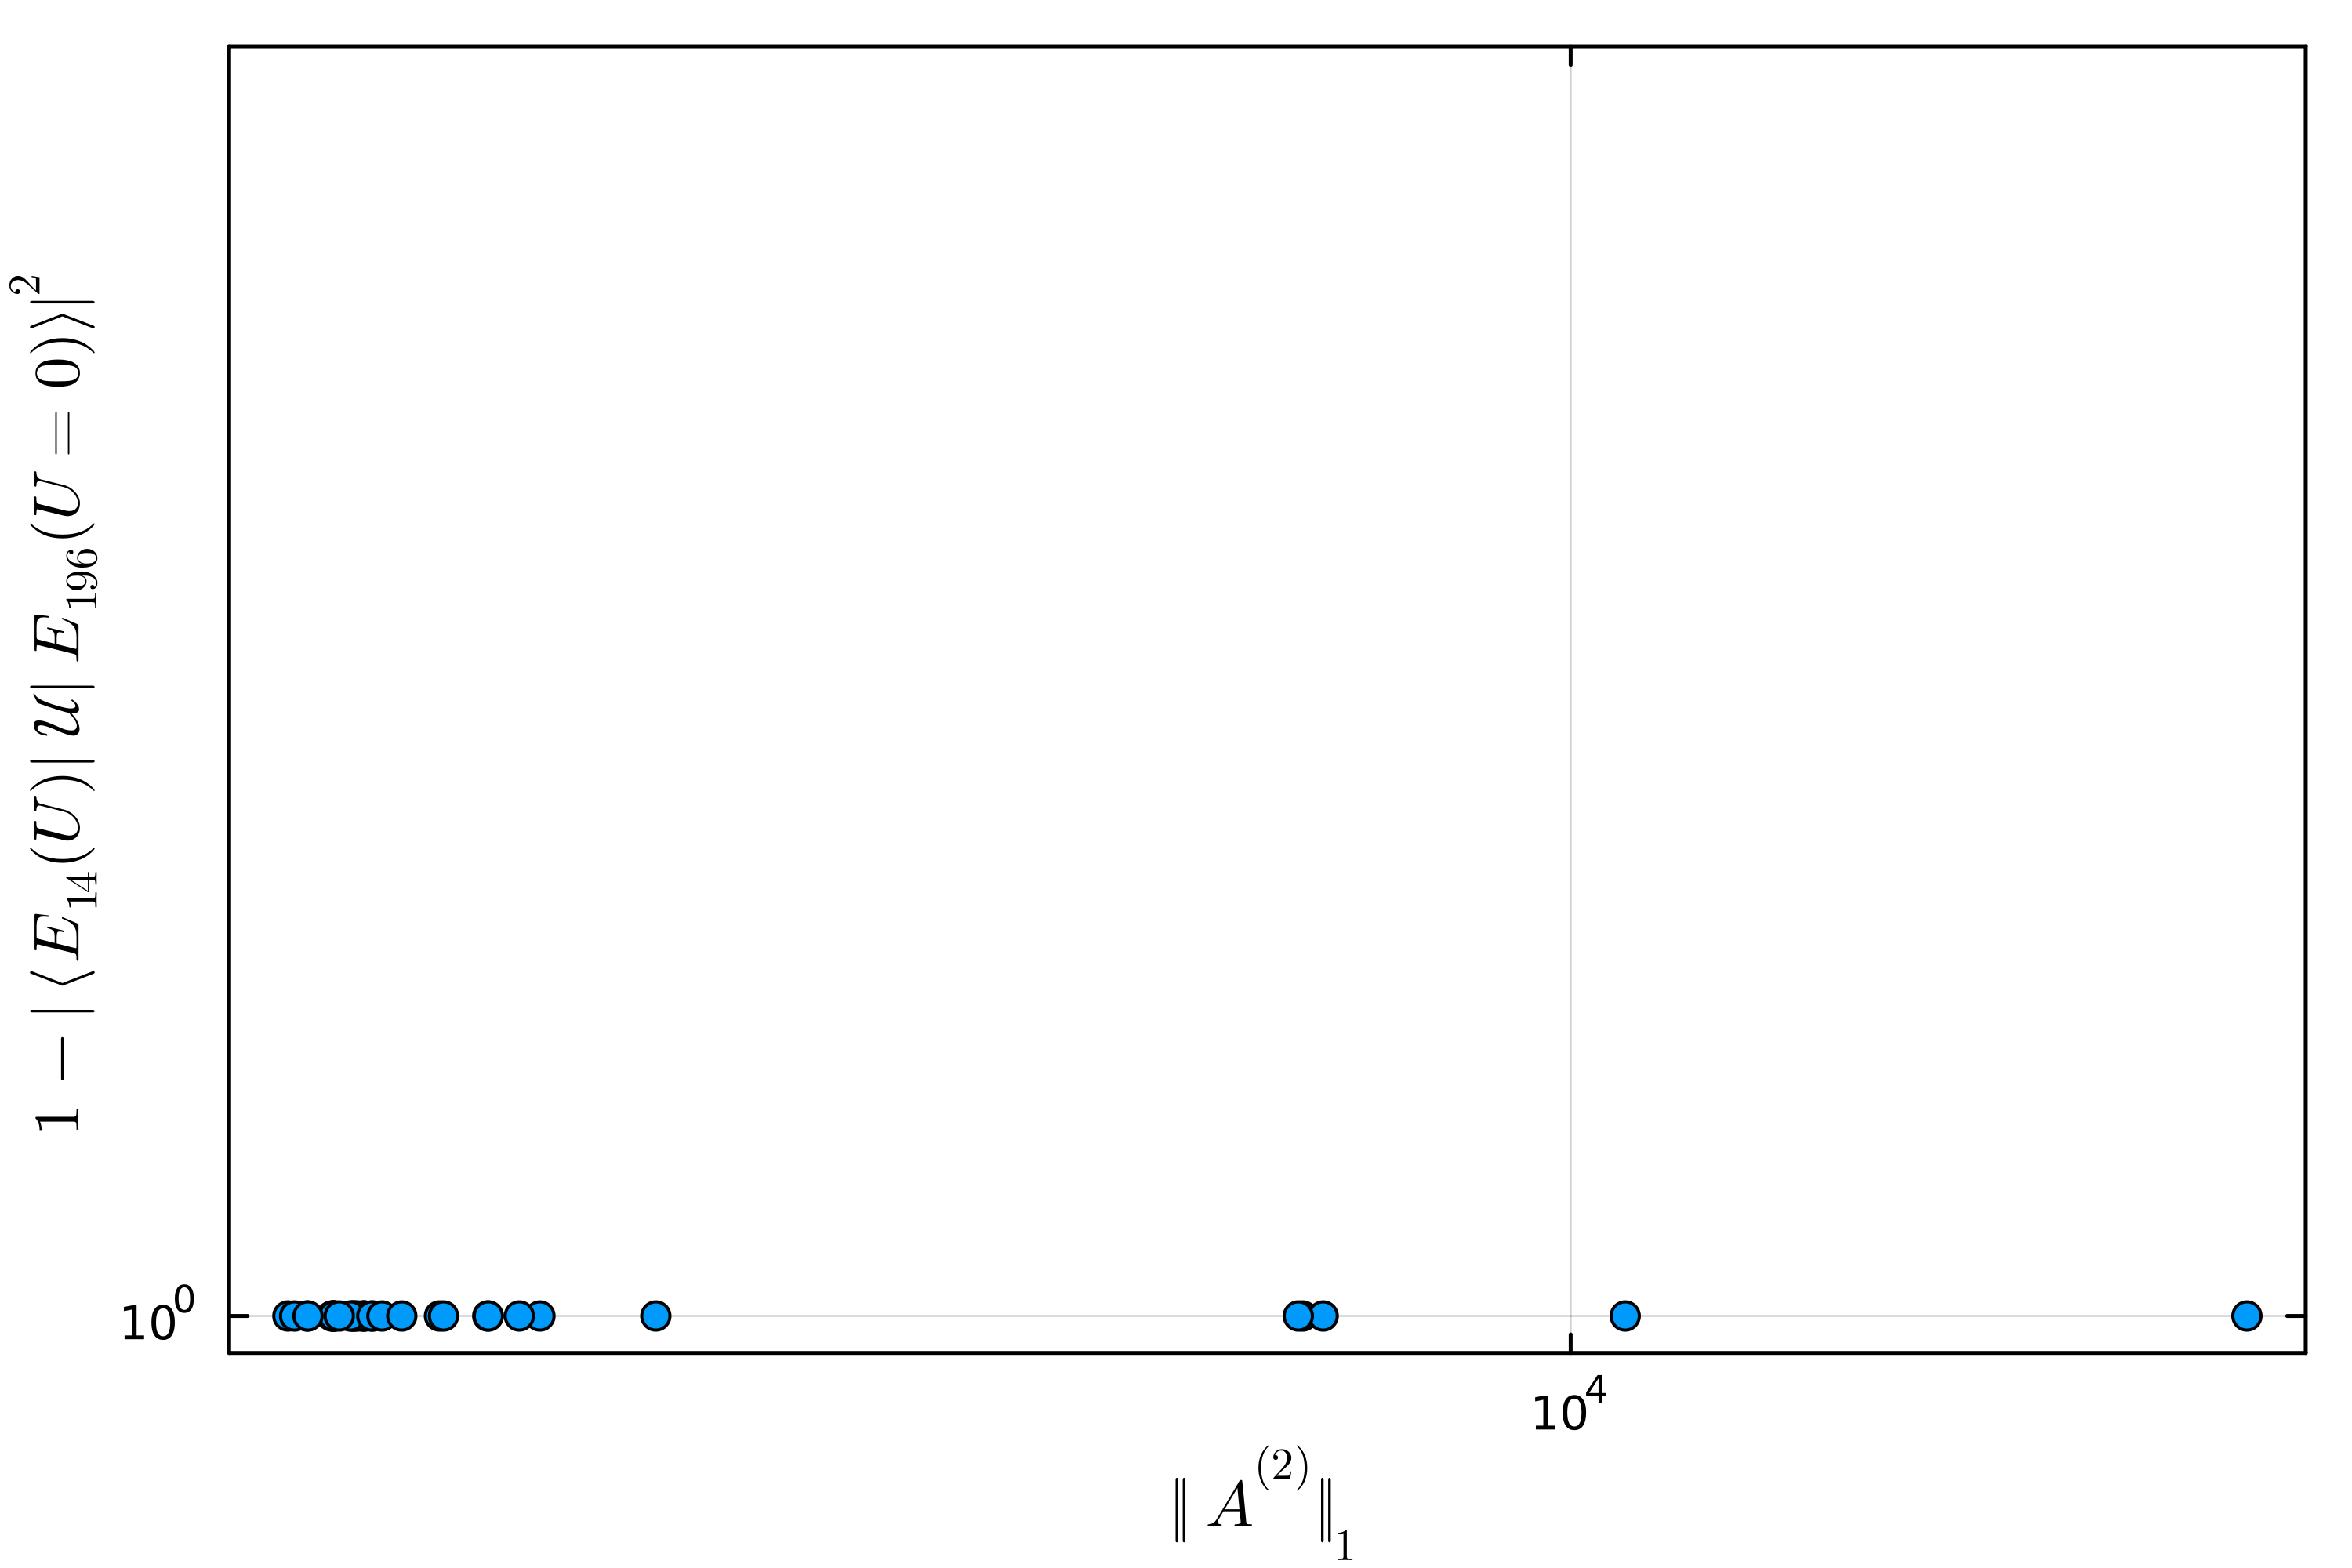

In [6]:
using Glob
n_electrons = 3
target_starting_level = 8
target_ending_level = 5

color_palette = Plots.palette(:seaborn_colorblind)
color_mapping = [color_palette[1], color_palette[2], color_palette[3]] # manually implemented for customization

i = 60
energy_i_map = sortperm(real.(diag(degen_rm_U[i]'*H[i]*degen_rm_U[i])))
inv_map = sortperm(energy_i_map)

# p1 = plot(legend=nothing, xlabel=L"U",yscale=:log10,xticks=10.0 .^(-10:10),yticks=10.0 .^(-10:10), xscale=:log10, 
#         ylabel=L"\Vert A^{(2)}\Vert_1",dpi=500)

# legend_location = :topleft
# p1 = plot(legend=nothing, xlabel=L"U",yscale=:log10,xticks=10.0 .^(-10:10),yticks=10.0 .^(-10:10), xscale=:log10, 
#          ylabel=L"\Vert A^{(2)}\Vert_1",dpi=500, framestyle=:box)
# p2 = plot(legend=legend_location, ylabel=L"1-|\langle E_{1}(U) |\mathcal{U}|E_{1}(U=0)\rangle|^2",yscale=:log10, xscale=:log10,
#      yticks=10.0 .^(-10:10),xticks=10.0 .^(-10:10),xlabel=L"\Vert A^{(n)}\Vert_1",dpi=500, framestyle=:box)
# p3 = plot(legend=legend_location, ylabel=L"1-|\langle E_{1}(U) |\mathcal{U}|E_{1}(U=0)\rangle|^2",yscale=:log10, xscale=:log10,
#      yticks=10.0 .^(-10:10),xticks=10.0 .^(-10:10),xlabel=L"U",dpi=500, framestyle=:box)
# p4 = plot(legend=nothing, ylabel=L"1-|\langle E_{1}(U) |E_{1}(U=0)\rangle|^2",yscale=:log10, xscale=:log10,
#      yticks=10.0 .^(-10:10),xticks=10.0 .^(-10:10),xlabel=L"\Vert A^{(2)}\Vert_1",dpi=500, framestyle=:box)
# initial_loss = []

legend_location = :left
p1 = plot(legend=legend_location, xlabel=L"U",yscale=:log10,xticks=10.0 .^(-10:10),yticks=10.0 .^(-10:10), xscale=:log10, 
         ylabel=L"\Vert A^{(n)}\Vert_1",dpi=500, framestyle=:box)
p2 = plot(legend=legend_location, ylabel=L"1-|\langle E_{%$(inv_map[target_ending_level])}(U) |\mathcal{U}|E_{%$(inv_map[target_starting_level])}(U=0)\rangle|^2",yscale=:log10, xscale=:log10,
     yticks=10.0 .^(-10:10),xticks=10.0 .^(-10:10),xlabel=L"\Vert A^{(n)}\Vert_1",dpi=500, framestyle=:box)
p3 = plot(legend=legend_location, ylabel=L"1-|\langle E_{%$(inv_map[target_ending_level])}(U)|\mathcal{U}|E_{%$(inv_map[target_starting_level])}(U=0)\rangle|^2",yscale=:log10, xscale=:log10,
     yticks=10.0 .^(-10:10),xticks=10.0 .^(-10:10),xlabel=L"U",dpi=500, framestyle=:box)
p4 = plot(legend=nothing, ylabel=L"1-|\langle E_{%$(inv_map[target_ending_level])}(U) |\mathcal{U}|E_{%$(inv_map[target_starting_level])}(U=0)\rangle|^2",yscale=:log10, xscale=:log10,
     yticks=10.0 .^(-10:10),xticks=10.0 .^(-10:10),xlabel=L"\Vert A^{(2)}\Vert_1",dpi=500, framestyle=:box)
initial_loss = []

println("HEY")
# folder = glob"single_particle_equal_state_interaction_unitary_tests*"
# folder = glob"*"


folder = glob"unitary_map_N=3_1"
for i = 1:2
    norm_list = []
    _U_values = []
    losses = []
    for path in readdir(folder, "data")
        data_dict3 = load_json_folder(path)
        if data_dict3["meta_data"]["electron count"] != n_electrons
            continue
        end
        for (label, v, loss) in zip(data_dict3["labels"], data_dict3["norm1_metrics"], data_dict3["loss_metrics"])
            if (length(v) < 2 || label["starting state"]["level"] != target_starting_level ||
                 label["ending state"]["level"] != target_ending_level
                #  || label["starting state"]["level"] == label["ending state"]["level"]
                 )
                continue
            end
            # println(label["starting state"]["level"], " ", label["ending state"]["level"])
            push!(norm_list, v[i])
            push!(_U_values, data_dict3["meta_data"]["U_values"][label["ending state"]["U index"]])
            push!(losses, loss[1+i])
            if i == 1
                push!(initial_loss, loss[1])
            end
            # if length(v) >= 2
            #     println("$(label["starting state"]["level"]) $(v[2])")
            # else
            #     println("$(label["starting state"]["level"]) 0")
            # end
        end
    end
    println("YOU")
    j = sortperm(_U_values)
    # peak_i = argmax(diff(y[j]))
    # println(U_values[j][peak_i])

    # if i == 2
        scatter!(p1, _U_values[j][3:end], norm_list[j][3:end], label=L"n=%$i", color=color_mapping[i+1])
    # end
    scatter!(p2, norm_list[j], losses[j], label=L"n=%$i", color=color_mapping[i+1])

    if i==1
        scatter!(p3, [],[], label=L"n=0", color=color_mapping[1], marker=:xcross, markersize=4) # plotting nothing to change ordering on legend
    end
    scatter!(p3, _U_values[j], losses[j], label=L"n=%$i", color=color_mapping[i+1])
    if i == 1
        scatter!(p3, _U_values[j], initial_loss[j], label="", color=color_mapping[1], marker=:xcross, markersize=4)
    end

    if i == 2
        scatter!(p4, norm_list[j][3:end], initial_loss[j][3:end])
    end
end

for p in [p1, p2, p3, p4]
    # if p != p2
    #     vline!(p,[5], c="black", linestyle=:dash, label=L"U=5")
    # end
    display(p)
end
variation = "random" #target_starting_level #"random"
for filetype in ["png", "svg", "pdf"]
    savefig(p1, "single_state_map_images/U_norm1_$variation.$filetype")
    savefig(p2, "single_state_map_images/loss_norm1_$variation.$filetype")
    savefig(p3, "single_state_map_images/U_loss_$variation.$filetype")
    savefig(p4, "single_state_map_images/overlap_comparison_$variation.$filetype")
end

ED

In [ ]:
t_dict1 = Dict{Vector{Tuple{Coordinate{2,Int64},Int,Symbol}}, Float64}()
for σ1 in 1:2
    for σ2 in 1:2
        for (i,s1) in enumerate(indexer.a)
            for j in i:length(indexer.a)
                s2 = indexer.a[j]
                if [(s1, σ1,:create), (s2, σ2, :annihilate)] ∉ keys(t_dict1)
                    t_dict1[[(s1, σ1,:create), (s2, σ2, :annihilate)]] = 0.5*rand()
                else
                    t_dict1[[(s1, σ1,:create), (s2, σ2, :annihilate)]] += 0.5*rand()
                end
            end
        end
    end
end
# for σ in 1:2
#     for s1 in indexer.a
#         if [(s1, σ,:create), (s1, σ, :annihilate)] ∉ keys(t_dict)
#             t_dict[[(s1, σ,:create), (s1, σ, :annihilate)]] = 100
#         else
#             t_dict[[(s1, σ,:create), (s1, σ, :annihilate)]] += 100
#         end
#     end
# end
t_dict2 = Dict{Vector{Tuple{Coordinate{2,Int64},Int,Symbol}}, Float64}()
for s1 in indexer.a
    if [(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)] ∉ keys(t_dict2)
        t_dict2[[(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)]] = 1
    else
        t_dict2[[(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)]] += 1
    end
end
target_dims = (length(indexer.inv_comb_dict), length(indexer.inv_comb_dict))
rows = Int[]
cols = Int[]
vals = Float64[]
general_n_body!(rows, cols, vals, t_dict1, indexer)
hopping = Matrix(Hermitian(sparse(rows, cols, vals,target_dims..., )))

rows = Int[]
cols = Int[]
vals = Float64[]
general_n_body!(rows, cols, vals, t_dict2, indexer)
interaction = Matrix(Hermitian(sparse(rows, cols, vals,target_dims...)))

EXP(state, M) = state'*M*state
var(state, M) = state'*M^2*state - (state'*M*state)^2
cov(state, A, B) = EXP(state, A*B) - EXP(state, A)*EXP(state, B)
state = normalize(randn(target_dims[1]))
# for i in 1:10000
#     state = normalize(randn(target_dims[1]))
#     if var(state, interaction-hopping) < var(state, interaction)
#         println("worked")
#     end
# end
println(cov(state, hopping, interaction))
println(var(state, hopping))
# size(interaction)
